In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import sem, wilcoxon
from scipy.signal import medfilt

In [2]:
def smooth(a, kernel):
    b=np.convolve(a,kernel,'same')/np.convolve(np.ones(a.shape),kernel,'same')
    return b

In [3]:
vol_file = Path('analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

sigma=60;
short_kernel=(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(np.arange(-sigma*3,sigma*3)**2)/(2*sigma**2))

In [25]:
def plot_subvolt(row, isplot=True):
    folder = row['folder']
    fish = row['fish']
    
    print(f'Processing {folder} {fish}')
    if row['task'][0] != 'R':
        return None
    
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.median(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
    
    subvolt = dff.copy()
    smooth_spk = spk.copy()
    for n, ndff in enumerate(dff):
        subvolt[n, :] = medfilt(ndff, kernel_size=151)
        smooth_spk[n, :] = smooth(smooth_spk[n,:], short_kernel)
        
    delay_starts = frame_stimParams[2,:]==3
    delay_starts = np.where(np.diff(delay_starts.astype('int'))==1)[0]
    task_type = frame_stimParams[3,:][delay_starts]
    num_trial = len(delay_starts)
    num_t = 3000

    act_delay_sub = np.zeros((num_cell, num_t, num_trial))
    act_delay_spk = np.zeros((num_cell, num_t, num_trial))

    for n_delay in range(num_trial):
        delay_ = delay_starts[n_delay]
        act_delay_sub[:, :, n_delay] = subvolt[:, delay_:delay_+num_t] - subvolt[:, delay_-10:delay_+10].mean(axis=-1, keepdims=True)
        act_delay_spk[:, :, n_delay] = smooth_spk[:, delay_:delay_+num_t]

    rank_cell = np.zeros(num_cell)
    for n_cell in range(num_cell):
        mean_act_list = []
        for n_task_type in range(1, 4):
            mean_act_list.append(act_delay_sub[n_cell, :, task_type==n_task_type].mean(axis=0))
        _, pval1 = wilcoxon(mean_act_list[0], mean_act_list[1])
        _, pval2 = wilcoxon(mean_act_list[1], mean_act_list[2])
        sig1 = np.median(mean_act_list[0]-mean_act_list[1])
        sig2 = np.median(mean_act_list[1]-mean_act_list[2])        
        if np.sign(sig1) == np.sign(sig2) and pval1<0.05 and pval2<0.05:
            rank_cell[n_cell] = 1
        if isplot:
            print([sig1, pval1, sig2, pval2])
            fig, ax = plt.subplots(1, 2, figsize=(20, 4))
            for n_task_type in range(1,4):
                ax[0].plot(np.arange(num_t)/300, act_delay_sub[n_cell, :, task_type==n_task_type].mean(axis=0), label=f'{n_task_type}')
                ax[1].plot(np.arange(num_t)/300, act_delay_spk[n_cell, :, task_type==n_task_type].mean(axis=0)*300, label=f'{n_task_type}')
                # ax[1].plot(n_task_type, act_delay_spk[n_cell, :, task_type==n_task_type].mean()*300, 'o', label=f'{n_task_type}')

            ax[0].set_xlim([0, num_t/300])
            ax[0].set_xlabel('Time from delay onset (sec)')
            ax[0].set_ylabel('df/f')
            ax[1].set_xlim([0, num_t/300])
            ax[1].set_xlabel('Time from delay onset (sec)')
            ax[1].set_ylabel('Spike rate')
            plt.legend()
            plt.show()
    return rank_cell

In [ ]:
rank_cell_list = []
for index, row in dat_xls_file.iterrows():
    _ = plot_subvolt(row, isplot=False)
    if _ is not None:
        rank_cell_list.append(_)

Processing 03152018 Fish1-1
Processing 03152018 Fish4-1
Processing 03152018 Fish4-2


In [ ]:
rank_cell_list_flat = np.concatenate(rank_cell_list)

In [ ]:
rank_cell_list_flat.mean()

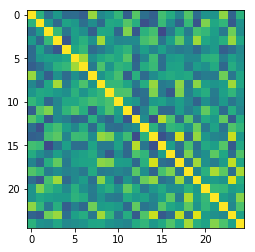

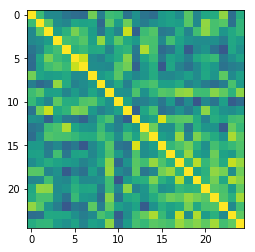

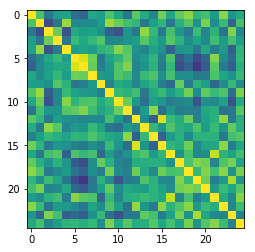

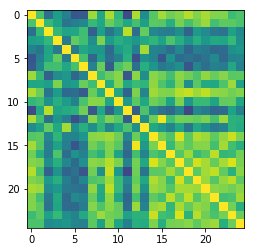

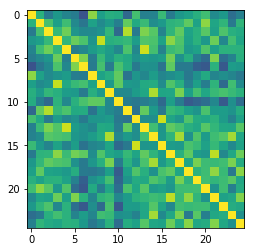

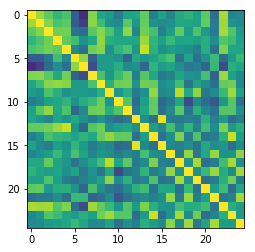

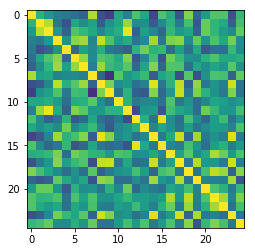

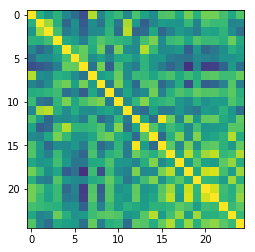

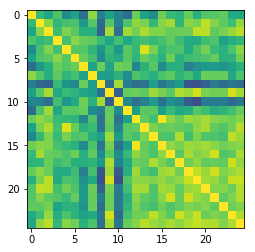

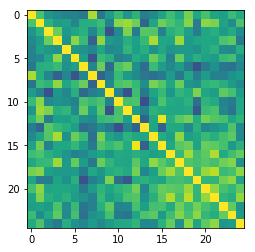

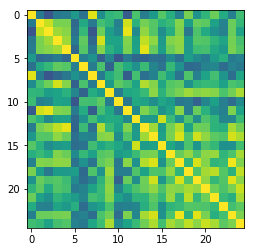

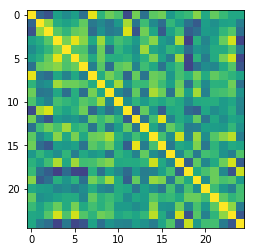

In [53]:
delay_starts = frame_stimParams[2,:]==3
delay_starts = np.where(np.diff(delay_starts.astype('int'))==1)[0]
task_type = frame_stimParams[3,:][delay_starts]
num_trial = len(delay_starts)
num_t = 1500

act_delay_sub = np.zeros((num_cell, num_t, num_trial))
act_delay_spk = np.zeros((num_cell, num_t, num_trial))
corr_sub = np.zeros((num_cell, num_cell, num_trial))

for n_delay in range(num_trial):
    delay_ = delay_starts[n_delay]
    act_delay_sub[:, :, n_delay] = subvolt[:, delay_:delay_+num_t] - subvolt[:, delay_-10:delay_+10].mean(axis=-1, keepdims=True)
    act_delay_spk[:, :, n_delay] = smooth_spk[:, delay_:delay_+num_t]

for n_delay in range(num_trial):
    n_dff = act_delay_sub[:, :, n_delay]
    corr_sub[:, :, n_delay] = np.corrcoef(n_dff)
    plt.imshow(corr_sub[:, :, n_delay], vmax=1, vmin=-1)
    plt.show()

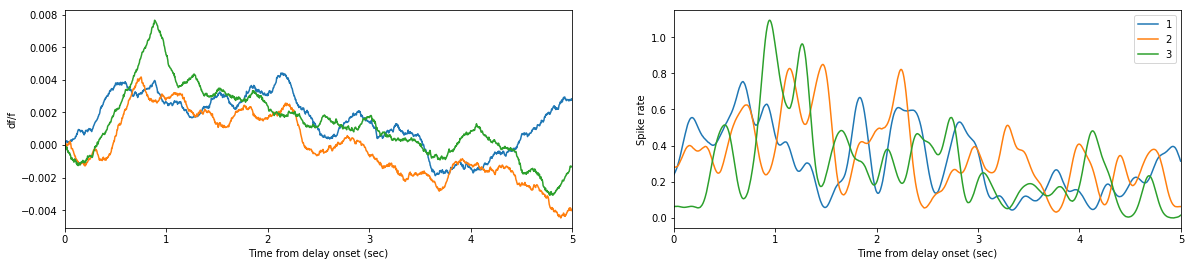

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
for n_task_type in range(1, 4):
    ax[0].plot(np.arange(num_t)/300, act_delay_sub[:, :, task_type==n_task_type].mean(axis=(0, -1)), label=f'{n_task_type}')
    ax[1].plot(np.arange(num_t)/300, act_delay_spk[:, :, task_type==n_task_type].mean(axis=(0, -1))*300, label=f'{n_task_type}')

ax[0].set_xlim([0, 5])
ax[0].set_xlabel('Time from delay onset (sec)')
ax[0].set_ylabel('df/f')
ax[1].set_xlim([0, 5])
ax[1].set_xlabel('Time from delay onset (sec)')
ax[1].set_ylabel('Spike rate')
plt.legend()
plt.show()

In [46]:
act_delay_sub[:, :, task_type==n_task_type].shape

(25, 1500, 4)